<a href="https://colab.research.google.com/github/componavt/differential_equations/blob/main/src/hill_equation/8_equation_multiplier_K.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧮 🔢 Numerical Solvers for Stiff Hill-Type ODE

- **Goal**: Analyze instability in the stiff ODE  
  $\frac{dx}{dt} = \frac{x^{1/\alpha}}{b^{1/\alpha} + x^{1/\alpha}}$  
- **Initial condition**: $x(0) \approx b = 1.0$  
- **Time interval**: $t \in [0, t_{\text{end}}]$  
- **Alpha range**: $\alpha \in [10^{-5}, 10^{-4}]$ (or as defined)  

## 🔧 Solvers
- 🚀 `RK45`: explicit with adaptive step size  
- 🛡️ `BDF`: designed for stiff equations  
- 💎 `Radau`: stable implicit method  

## 📊 Features
- Logarithmic spacing for `alpha`  
- Numerical stability guards and overflow protection  
- Annotated plots with labeled curves  
- Heatmap of maximum |dx/dt| over ($\alpha$, $x_0$)  
- Chaos boundary exploration  

In [16]:
# Cell 1: Parameters and library imports
b = 1.0
K = 2.4  # New multiplier in numerator
#x0 = b * 0.99999  # Initial condition x(0) ≈ b
x0 = b * (1 - 1e-11)
MAX_LOG_MESSAGES = 3
t_end = 0.05 # 0.4  # Right boundary for Time(t)

!pip install deepxde
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pickle


# Define Hill-type equation generator (DeepXDE neural network version)
#def get_hill_equation(alpha):
#  def hill_equation(x, y):
#     y_safe = tf.clip_by_value(y, 1e-6, 1e6)
#     dy_t = dde.grad.jacobian(y, x, i=0, j=0) # dy/dt
#     x_alpha = tf.pow(y_safe, 1 / alpha)      # x^(1/alpha)
#     b_alpha = tf.pow(b, 1 / alpha)           # b^(1/alpha)
#     return dy_t - x_alpha / (b_alpha + x_alpha)
#  return hill_equation


# Define Hill-type equation RHS (NumPy version)
def get_rhs(alpha, method_name, error_log):
    error_log.setdefault(method_name + '_msgs', 0)

    def rhs(t, x):
        x_safe = np.clip(x[0], 1e-6, 1e6)
        inv_alpha = 1 / alpha
        try:
            log_x = np.log(x_safe)
            log_b = np.log(b)

            # old version
            #x_alpha = np.exp(log_x * inv_alpha)
            #b_alpha = np.exp(log_b * inv_alpha)

            # Use numerically stable log-domain computation (new version)
            exp_power = log_x * inv_alpha
            exp_b_power = log_b * inv_alpha
            if exp_power > 700 or exp_b_power > 700:
                raise OverflowError("Exponential overflow detected")
            x_alpha = np.exp(exp_power)
            b_alpha = np.exp(exp_b_power)

            denom = b_alpha + x_alpha
            if np.isinf(denom) or np.isnan(denom):
                raise ValueError("Denominator became NaN or Inf")
            return [K * x_alpha / denom]
        except Exception as e:
            error_log[method_name] += 1
            if error_log[method_name + '_msgs'] < MAX_LOG_MESSAGES:
              msg = f"Numerical error in {method_name} at t={t:.5f}, x={x_safe:.5f}, alpha={alpha:.2e}: {e}"
              print(msg)
              error_log[method_name + '_msgs'] += 1
            return [0.0]
    return rhs



# Alpha range with potential small values (log-spaced)
#alpha = 0.01
#alpha_list = np.logspace(-2, -5, 10)  # от 0.01 до 0.00001 логарифмически
alpha_list = np.logspace(-4, -5, 10)  # от 1.0e-04 до 1.0e-05 (from 1e-4 to 1e-5)

#alpha_list = np.logspace(-2, -5, 3)  # от 0.01 до 0.00001 логарифмически
#alpha_list = np.logspace(-3, -7, 10)  # от 0.001 до 0.0000001: 2.78e-07 ok, 1.0e-07 NaN
#alpha_list = np.logspace(-5, -7, 10)  # от 0.00001 до 0.0000001
#alpha_list = np.logspace(-5, -6.11, 10)  # from 1e-5 to ~1.3e-6 # ok for NeuralNetwork
#alpha_list = np.logspace(-4, -9, 20)  # от 0.0001 до 0.000000001 логарифмически - много NaN

print("Alpha values:", alpha_list)

Alpha values: [1.00000000e-04 7.74263683e-05 5.99484250e-05 4.64158883e-05
 3.59381366e-05 2.78255940e-05 2.15443469e-05 1.66810054e-05
 1.29154967e-05 1.00000000e-05]


In [17]:
# Cell 2: Numerical solution with SciPy solvers

# Evaluation time points (uniform)
N = 500
t_eval = np.linspace(0, t_end, N) # [0, 1] or [0, 0.4]


# Solve and store results for all alpha values
all_results = {"combined": []}
error_counts = {"RK45": 0, "BDF": 0, "Radau": 0, "RK45_msgs": 0, "BDF_msgs": 0, "Radau_msgs": 0}
fail_counts = {"RK45": 0, "BDF": 0, "Radau": 0}
error_msg_limit = 3

used_colors = set()

total = len(alpha_list)
for index, alpha in enumerate(alpha_list):
    progress_percent = int((index + 1) / total * 100)
    print(f"[{progress_percent:3d}%] Solving for alpha = {alpha:.2e} ({index + 1}/{total})")

    alpha_label = f"α={alpha:.1e}"
    all_results[alpha_label] = []

    for method in ["RK45", "BDF", "Radau"]:
        rhs = get_rhs(alpha, method, error_counts)
        try:
            sol = solve_ivp(rhs, [0, t_end], [x0], t_eval=t_eval, method=method)
            all_results[alpha_label].append((sol.t, sol.y[0], method))
            all_results["combined"].append((sol.t, sol.y[0], method, alpha_label))
        except Exception as e:
            print(f"{method} failed for alpha={alpha:.2e}: {e}")
            fail_counts[method] += 1

# Save to file
with open("solvers_results.pkl", "wb") as f:
    pickle.dump(all_results, f)

print("\n=== Summary of failures ===")
for method in ["RK45", "BDF", "Radau"]:
    print(f"{method} failed {fail_counts[method]} times out of {total}")
    print(f"{method} numerical errors: {error_counts[method]} times out of {total * N}")

[ 10%] Solving for alpha = 1.00e-04 (1/10)
Numerical error in RK45 at t=0.03702, x=1.10180, alpha=1.00e-04: Exponential overflow detected
Numerical error in RK45 at t=0.02734, x=1.07519, alpha=1.00e-04: Exponential overflow detected
Numerical error in RK45 at t=0.02776, x=1.07409, alpha=1.00e-04: Exponential overflow detected
Numerical error in BDF at t=0.03853, x=1.09238, alpha=1.00e-04: Exponential overflow detected
Numerical error in BDF at t=0.03853, x=1.09238, alpha=1.00e-04: Exponential overflow detected
Numerical error in BDF at t=0.03853, x=1.09238, alpha=1.00e-04: Exponential overflow detected
Numerical error in Radau at t=0.03081, x=1.07514, alpha=1.00e-04: Exponential overflow detected
Numerical error in Radau at t=0.02201, x=1.12240, alpha=1.00e-04: Exponential overflow detected
Numerical error in Radau at t=0.03081, x=1.34690, alpha=1.00e-04: Exponential overflow detected
[ 20%] Solving for alpha = 7.74e-05 (2/10)
[ 30%] Solving for alpha = 5.99e-05 (3/10)
[ 40%] Solving f

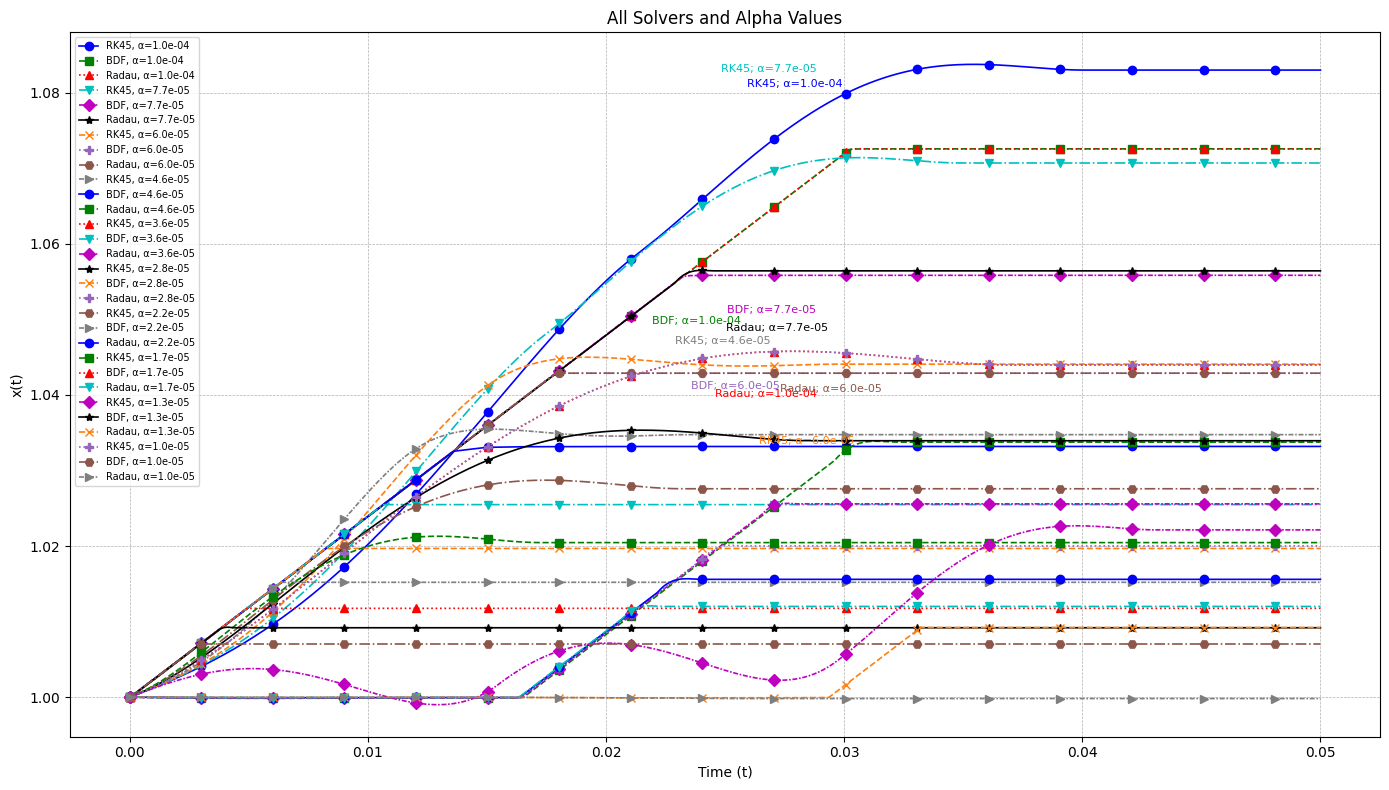

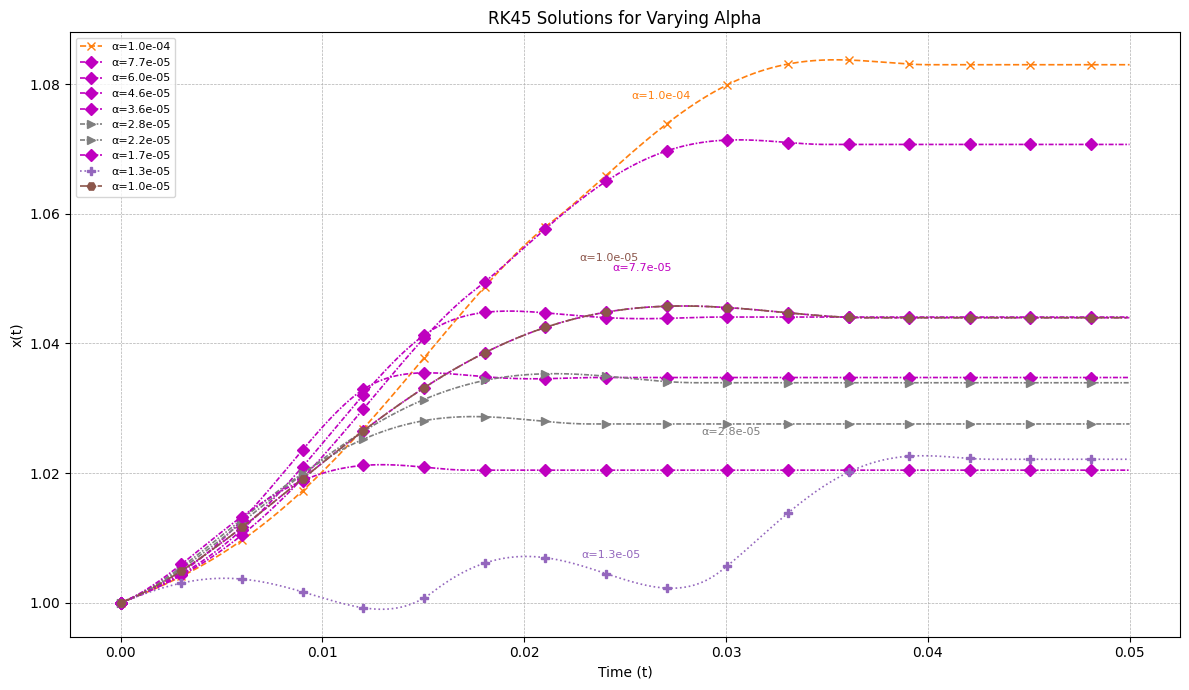

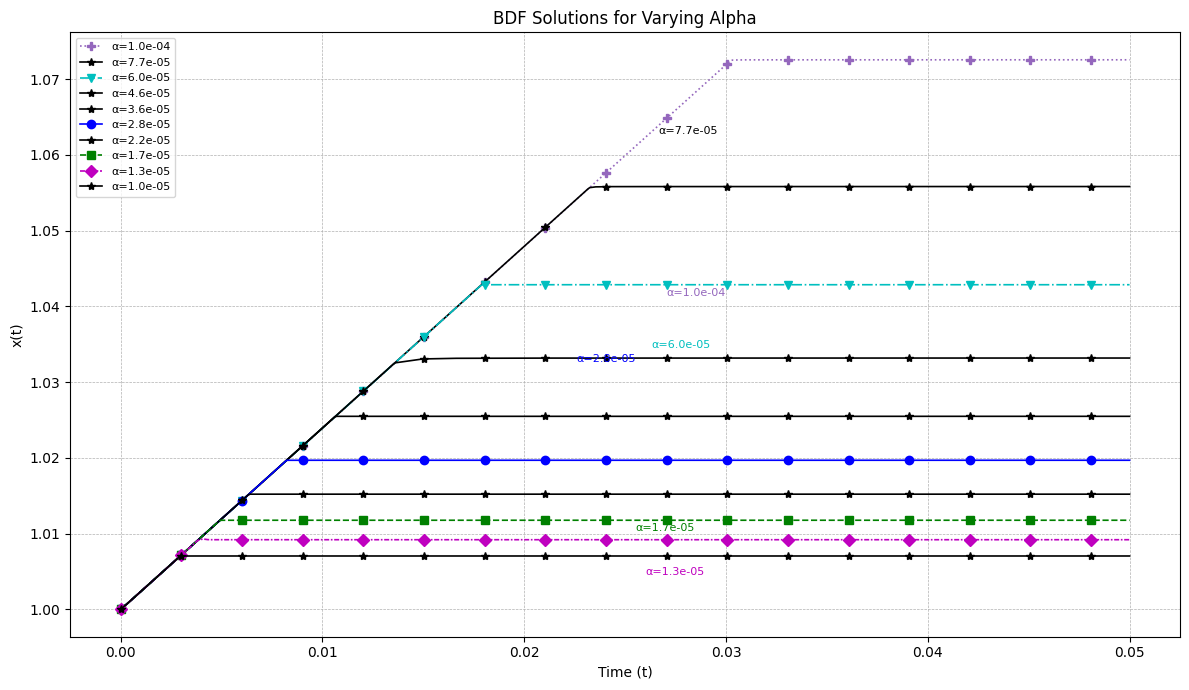

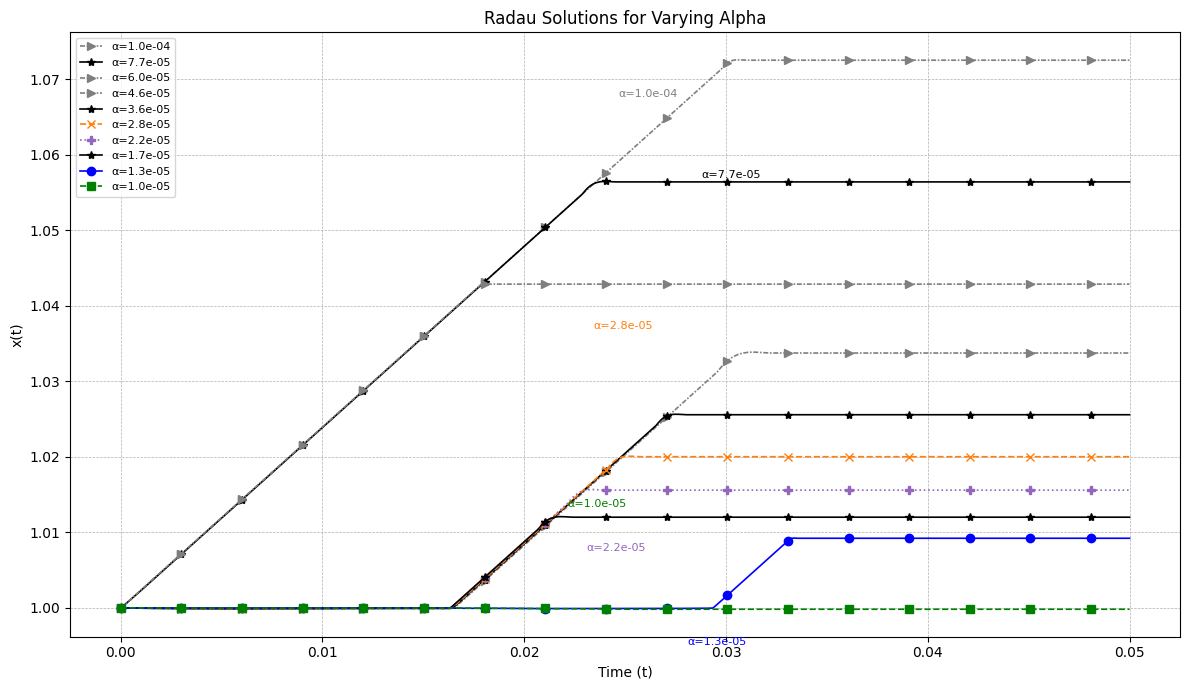

In [18]:
# Cell 3: Visualization block (can be run separately)
import matplotlib.pyplot as plt
import pickle

# Load previously saved results
with open("solvers_results.pkl", "rb") as f:
    all_results = pickle.load(f)

# Styling
linestyles = ['-', '--', ':', '-.', (0, (3, 1, 1, 1))]
markers = ['o', 's', '^', 'v', 'D', '*', 'x', 'P', 'H', '>']
colors = ['b', 'g', 'r', 'c', 'm', 'k', 'tab:orange', 'tab:purple', 'tab:brown', 'tab:gray']
used_colors = set()

# --- Combined plot for all solvers and alpha values ---
plt.figure(figsize=(14, 8))
for i, (t, x, method, alpha_label) in enumerate(all_results["combined"]):
    color = colors[i % len(colors)]
    marker = markers[i % len(markers)]
    linestyle = linestyles[i % len(linestyles)]
    label = f"{method}, {alpha_label}"
    plt.plot(t, x,
             linestyle=linestyle,
             color=color,
             marker=marker,
             markevery=30,
             label=label,
             linewidth=1.2)
    # Annotate once per color
    if color not in used_colors:
        idx = len(t) // 2
        x_offset = np.random.uniform(-0.08, 0.08) * t_end   # random horizontal offset
        y_offset = np.random.uniform(-0.02, 0.02) * x[idx]  # random vertical offset
        plt.text(t[idx] + x_offset, x[idx] + y_offset, f"{method}; {alpha_label}", fontsize=8, color=color)
        used_colors.add(color)

plt.xlabel("Time (t)")
plt.ylabel("x(t)")
plt.title("All Solvers and Alpha Values")
plt.legend(fontsize=7)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# --- Separate plots for each solver ---
methods = ["RK45", "BDF", "Radau"]
for method in methods:
    plt.figure(figsize=(12, 7))
    used_colors = set()
    for alpha_label, results in all_results.items():
        if alpha_label == "combined":
            continue
        for (t, x, label) in results:
            if label == method:
                i = hash((alpha_label, method)) % len(colors)
                color = colors[i % len(colors)]
                marker = markers[i % len(markers)]
                linestyle = linestyles[i % len(linestyles)]
                plt.plot(t, x,
                         linestyle=linestyle,
                         color=color,
                         marker=marker,
                         markevery=30,
                         label=f"{alpha_label}",
                         linewidth=1.2)
                if color not in used_colors:
                    idx = len(t) // 2
                    x_offset = np.random.uniform(-0.08, 0.08) * t_end
                    y_offset = np.random.uniform(-0.02, 0.02) * x[idx]
                    plt.text(t[idx] + x_offset, x[idx] + y_offset, alpha_label, fontsize=8, color=color)
                    used_colors.add(color)
    plt.xlabel("Time (t)")
    plt.ylabel("x(t)")
    plt.title(f"{method} Solutions for Varying Alpha")
    plt.legend(fontsize=8)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

[Heatmap] Starting computation...
Numerical error in RK45 at t=0.05000, x=1.01287, alpha=1.13e-05: Exponential overflow detected
Numerical error in RK45 at t=0.05000, x=1.02047, alpha=1.13e-05: Exponential overflow detected
Numerical error in RK45 at t=0.04843, x=1.00959, alpha=1.13e-05: Exponential overflow detected
Numerical error in RK45 at t=0.05000, x=1.03430, alpha=1.27e-05: Exponential overflow detected
Numerical error in RK45 at t=0.05000, x=1.07811, alpha=1.27e-05: Exponential overflow detected
Numerical error in RK45 at t=0.03392, x=1.01334, alpha=1.27e-05: Exponential overflow detected
Numerical error in RK45 at t=0.04000, x=1.17175, alpha=1.44e-05: Exponential overflow detected
Numerical error in RK45 at t=0.04444, x=1.47418, alpha=1.44e-05: Exponential overflow detected
Numerical error in RK45 at t=0.05000, x=1.42985, alpha=1.44e-05: Exponential overflow detected
Numerical error in RK45 at t=0.03691, x=1.38425, alpha=1.62e-05: Exponential overflow detected
Numerical error 

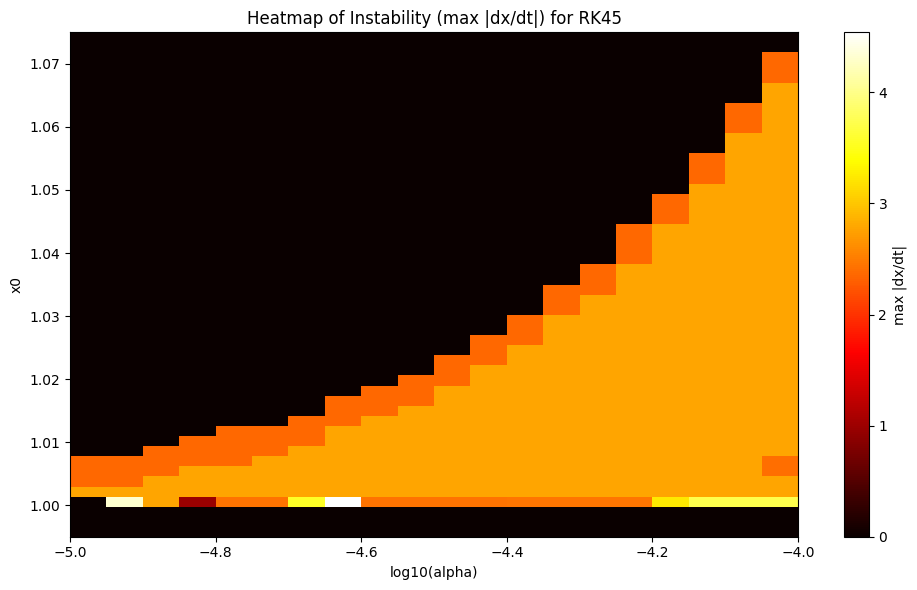

In [19]:
# Cell 4: Heatmap of instability region (dx/dt)
print("[Heatmap] Starting computation...")
alpha_vals = np.logspace(-5, -4, 20)  # narrower range where instability occurs, old: (-4, -5, 20)
x0_vals = np.linspace(0.995, 1.075, 50)  # focused x0 range, old: (0.9 * b, 1.01 * b, 50)

dxdt_map = np.zeros((len(x0_vals), len(alpha_vals)))

for i, x0_test in enumerate(x0_vals):
    for j, alpha_test in enumerate(alpha_vals):
        percent = int(((i * len(alpha_vals) + j + 1) / (len(alpha_vals) * len(x0_vals)))*100)
        print(f"[Heatmap] {percent:3d}% done", end='\r')
        try:
            rhs = get_rhs(alpha_test, "RK45", {"RK45": 0, "RK45_msgs": 0})
            sol = solve_ivp(rhs, [0, t_end], [x0_test], t_eval=t_eval, method='RK45')
            dxdt = np.gradient(sol.y[0], sol.t)
            dxdt_map[i, j] = np.max(np.abs(dxdt))
        except:
            dxdt_map[i, j] = np.nan

from matplotlib import colormaps
cmap = colormaps.get_cmap('hot').copy()
cmap.set_bad(color='blue')

plt.figure(figsize=(10, 6))
plt.imshow(np.ma.masked_invalid(dxdt_map),
           extent=[np.log10(alpha_vals[0]), np.log10(alpha_vals[-1]), x0_vals[0], x0_vals[-1]],
           origin='lower', aspect='auto', cmap=cmap)
plt.colorbar(label='max |dx/dt|')
plt.xlabel('log10(alpha)')
plt.ylabel('x0')
plt.title('Heatmap of Instability (max |dx/dt|) for RK45')
plt.tight_layout()
plt.show()